In [9]:
import pyspark
import dxpy
import dxdata
!which java

/opt/conda/bin/java


In [10]:
# spark initialization
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

# find dispensed database name and dataset id
dispensed_database = dxpy.find_one_data_object(
    classname='database', 
    name='app*', 
    folder='/', 
    name_mode='glob', 
    describe=True)
dispensed_database_name = dispensed_database['describe']['name']

dispensed_dataset = dxpy.find_one_data_object(
    typename='Dataset', 
    name='app*.dataset', 
    folder='/', 
    name_mode='glob')
dispensed_dataset_id = dispensed_dataset['id']

dataset = dxdata.load_dataset(id=dispensed_dataset_id)
participant = dataset['participant']

Some helper functions to get field IDs

In [11]:
def fields_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

def field_names_for_id(field_id):
    return [f.name for f in fields_for_id(field_id)]

def fields_by_title_keyword(keyword):
    from distutils.version import LooseVersion
    fields = list(participant.find_fields(lambda f: keyword.lower() in f.title.lower()))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

def field_names_by_title_keyword(keyword):
    return [f.name for f in fields_by_title_keyword(keyword)]

def field_titles_by_title_keyword(keyword):
    return [f.title for f in fields_by_title_keyword(keyword)]

get selected field IDs from dataset

In [ ]:
match_variables = [
                    'sex_f31_0_0', 'age_when_attended_assessment_centre_f21003_0_0',
                    'uk_biobank_assessment_centre_f54_2_0', 'uk_biobank_assessment_centre_f54_3_0',
                    'loud_music_exposure_frequency_f4836_0_0',
                    'noisy_workplace_f4825_0_0', 'cochlear_implant_f4792_0_0',
                    'hearing_aid_user_f3393_0_0', 'hearing_difficultyproblems_with_background_noise_f2257_0_0',
                    'handedness_chiralitylaterality_f1707_0_0', 'alcohol_intake_frequency_f1558_0_0',
                    'average_total_household_income_before_tax_f738_0_0',
                    'speechreceptionthreshold_srt_estimate_left_f20019_0_0',
                    'speechreceptionthreshold_srt_estimate_right_f20021_0_0'
                    ]

tinnitus_field_ids = ['p4803_i0', 'p4803_i2', 'p4814_i0', 'p28625'] # added extra tinnitus

mr_variables = ['p26501_i2', 'p26501_i3'] # to see if they exist

demographic_field_ids = [
                        'eid',
                        'p31', 'p21003_i0',
                        'p54_i2', 'p54_i3',
                        'p4836_i0',
                        'p4825_i0', 'p4792_i0',
                        'p3393_i0', 'p2257_i0',
                        'p1707_i0', 'p1558_i0',
                        'p738_i0',
                        'p20019_i0', 'p20021_i0'
                        ] + \
                        tinnitus_field_ids + \
                        mr_variables

df = participant.retrieve_fields(
        names=demographic_field_ids,
        engine=dxdata.connect()
    )
df.toPandas().to_csv('ukb_demographics.csv', index=False)
!dx upload ukb_demographics.csv --dest / 

Assuming you have the ukb_demographics.csv, let's prepare columns to be ready for matching

In [ ]:
import re
import pandas as pd

## read file
df = pd.read_csv("ukb_demographics.csv")

## map column names
match_variables = [
                    'sex_f31_0_0', 'age_when_attended_assessment_centre_f21003_0_0',
                    'uk_biobank_assessment_centre_f54_2_0', 'uk_biobank_assessment_centre_f54_3_0',
                    'loud_music_exposure_frequency_f4836_0_0',
                    'noisy_workplace_f4825_0_0', 'cochlear_implant_f4792_0_0',
                    'hearing_aid_user_f3393_0_0', 'hearing_difficultyproblems_with_background_noise_f2257_0_0',
                    'handedness_chiralitylaterality_f1707_0_0', 'alcohol_intake_frequency_f1558_0_0',
                    'average_total_household_income_before_tax_f738_0_0',
                    'speechreceptionthreshold_srt_estimate_left_f20019_0_0',
                    'speechreceptionthreshold_srt_estimate_right_f20021_0_0'
                    ]
tinnitus_field_names = ['tin_status_1', 'tin_status_2', 'tin_severity', 'tin_duration']
new_col_names = ["subject_id", "sex", "age", "center_v2", "center_v3"] + \
            [re.split(r'_f\d+', s)[0] for s in match_variables[4:]] + \
            tinnitus_field_names + \
            ["Mean_intensity_v2", "Mean_intensity_v3"]


mapping = dict(zip(
                list(df.columns),
                new_col_names
                ))
df.rename(columns=mapping, inplace=True)

## fixing tinnitus status
cols = ["tin_status_1", "tin_status_2"]
mapping = {0: 0, 11: 1}
df[cols] = df[cols].apply(lambda s: s.map(mapping))
df = df.dropna(subset=cols, how="all")
df = df[
    (df["tin_status_1"] == df["tin_status_2"]) |
    (df["tin_status_1"].isna()) |
    (df["tin_status_2"].isna())
]

df["tin_status"] = df["tin_status_1"].combine_first(df["tin_status_2"])
df = df.drop(columns=["tin_status_1", "tin_status_2"])

## HL fix
col = 'hearing_difficultyproblems_with_background_noise'
df[col] = df[col].map({0: 0, 1: 1})
df.dropna(subset=[col], inplace=True)

## helper function to clean the df
def replace_and_fill_mode(df, column, to_replace=None):
    """
    Replace specific values with NaN and fill missing values with the mode.
    
    Parameters:
        df: pandas DataFrame
        column: column name as string
        to_replace: list of values to replace with NaN (default ['Prefer not to answer', 'Do not know'])
    """
    if to_replace is None:
        to_replace = ['Prefer not to answer', 'Do not know']
    
    df[column].replace(to_replace, pd.NA, inplace=True)
    df[column].fillna(df[column].mode()[0], inplace=True)

# apply the helper function on these columns
replace_fill_cols = {
    'handedness_chiralitylaterality': ['Prefer not to answer'],
    'average_total_household_income_before_tax': ['Prefer not to answer', 'Do not know'],
    'loud_music_exposure_frequency': ['Prefer not to answer', 'Do not know'],
    'noisy_workplace': ['Prefer not to answer', 'Do not know'],
    'cochlear_implant': ['Prefer not to answer'],
    'hearing_aid_user': ['Prefer not to answer'],
    'hearing_difficultyproblems_with_background_noise': ['Prefer not to answer', 'Do not know'],
    'alcohol_intake_frequency': ['Prefer not to answer']
}

for col, values in replace_fill_cols.items():
    replace_and_fill_mode(df, col, to_replace=values)

# drop rows with missing critical data
df.dropna(subset=[
    'speechreceptionthreshold_srt_estimate_left',
    'speechreceptionthreshold_srt_estimate_right'
    ], how='any', inplace=True)

## get only subjects that have MRI at least in one visit
df.dropna(subset=["Mean_intensity_v2", "Mean_intensity_v3"], how='all', inplace=True)

## save
df.to_csv("ukb_demographics_ready_for_matching.csv", index=False)
!dx upload ukb_demographics_ready_for_matching.csv --dest / 

Matching in R (change the Kernel)

In [2]:
install.packages("MatchIt")
install.packages("cobalt")
install.packages("gtsummary")
install.packages("broom", repos = "https://cloud.r-project.org")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘chk’, ‘RcppProgress’





Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


 cobalt (Version 4.6.1, Build Date: 2025-08-20)


Attaching package: ‘cobalt’


The following object is masked from ‘package:MatchIt’:

    lalonde




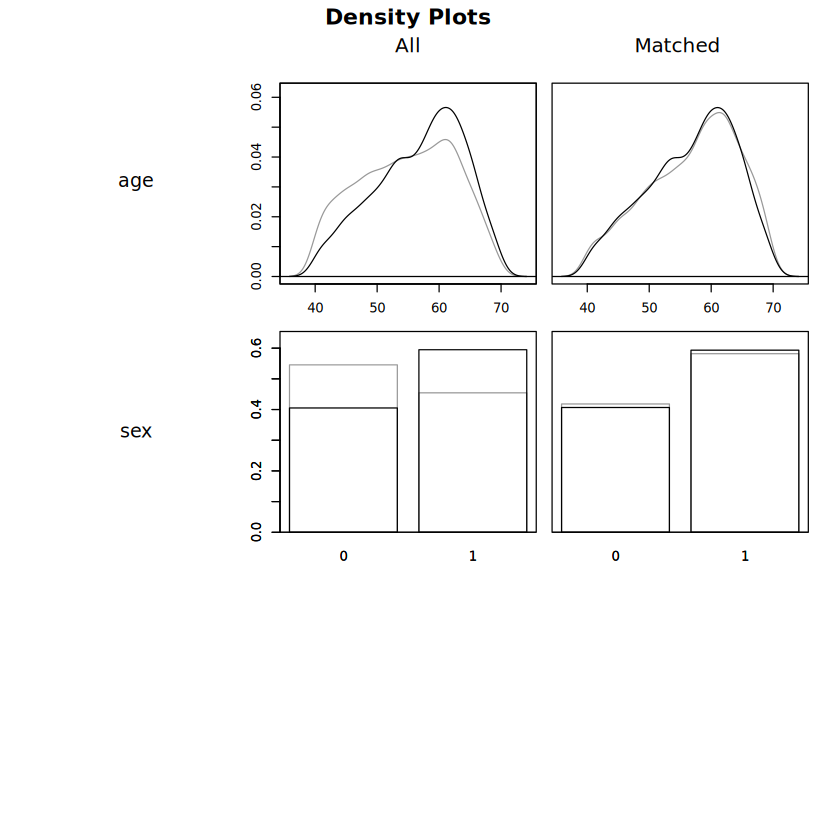

In [1]:
rm(list = ls())
cat("\014")

library(MatchIt)
library(dplyr)
library(tidyr)
library(cobalt)
library(gtsummary)

## load data
dat <- read.csv("ukb_demographics_ready_for_matching.csv")

# define matching variables
match_vars <- c(
  "sex",
  "age",
  "loud_music_exposure_frequency",
  "noisy_workplace",
  "hearing_aid_user",
  "hearing_difficultyproblems_with_background_noise",
  "handedness_chiralitylaterality",
  "alcohol_intake_frequency",
  "average_total_household_income_before_tax",
  "speechreceptionthreshold_srt_estimate_left",
  "speechreceptionthreshold_srt_estimate_right"
)

## preprocessing
dat <- dat %>%
  mutate(
    tin_status = factor(tin_status),
    sex = factor(sex),
    loud_music_exposure_frequency = factor(loud_music_exposure_frequency),
    noisy_workplace = factor(noisy_workplace),
    hearing_aid_user = factor(hearing_aid_user),
    hearing_difficultyproblems_with_background_noise =
      factor(hearing_difficultyproblems_with_background_noise),
    handedness_chiralitylaterality =
      factor(handedness_chiralitylaterality),
    alcohol_intake_frequency = factor(alcohol_intake_frequency),
    average_total_household_income_before_tax =
      factor(average_total_household_income_before_tax)
  ) %>%
  drop_na(all_of(c("tin_status", match_vars)))

## matching
match_formula <- as.formula(
  paste("tin_status ~", paste(match_vars, collapse = " + "))
)
m.out <- matchit(
  formula = match_formula,
  data = dat,
  method = "nearest",
  ratio = 1,
  caliper = 0.2,
  replace = FALSE
)

# saving the matched dataset
matched_index <- rownames(match.data(m.out))
matched_data <- dat[as.numeric(matched_index), ]
write.csv(matched_data, "ukb_demographics_matched.csv", row.names = FALSE)


## plotting
# quartz()
# summary(m.out)
# plot(m.out)
# plot(m.out, type = "jitter", interactive = FALSE)
plot(m.out, type = "density", interactive = FALSE,
     which.xs = ~age + sex)

## stat summery
summary_tbl <- matched_data %>%
    select(tin_status, age, sex) %>%
    tbl_summary(
        by = tin_status,
        statistic = list(
            all_continuous() ~ "{mean} ± {sd}",
            all_categorical() ~ "{n} ({p}%)"
        ),
        digits = all_continuous() ~ 1
    ) %>%
    add_p() %>%
    bold_labels()

summary_tbl %>%
  as_gt() %>%
  gt::gtsave("summary_table.html")



In [1]:
!dx upload ukb_demographics_matched.csv --dest / 
!dx upload summary_table.html --dest / 

[===========================================================>] Uploaded 365,330 of 365,330 bytes (100%) ukb_demographics_matched.csv
ID                                file-J5xVkV8J0Q60qkg16bp8pJ71
Class                             file
Project                           project-J5jvKY8J0Q6GZQ5xxKzgF5Kb
Folder                            /
Name                              ukb_demographics_matched.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Jan 29 08:39:33 2026
Created by                        payam
 via the job                      job-J5xV5G0J0Q62pJQ1Py59vVz2
Last modified                     Thu Jan 29 08:39:34 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
[==============

/tmp/ipykernel_2730/2218152082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["sex"] = df_plot["sex"].map({0: "Female", 1: "Male"})
/tmp/ipykernel_2730/2218152082.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["tin_status"] = df_plot["tin_status"].map({0: "Control", 1: "Tinnitus"})
/opt/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating in

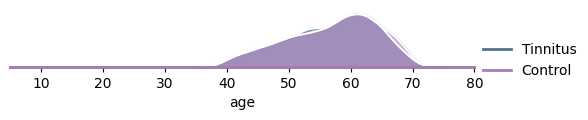

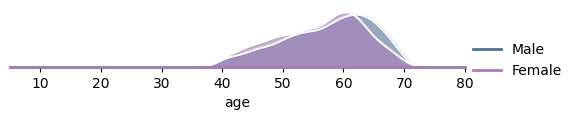

In [3]:
## plotting distribution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_matched = pd.read_csv("ukb_demographics_matched.csv")
df_plot = df_matched[["age", "sex", "tin_status"]]

df_plot["sex"] = df_plot["sex"].map({0: "Female", 1: "Male"})
df_plot["tin_status"] = df_plot["tin_status"].map({0: "Control", 1: "Tinnitus"})

pal = [
        sns.cubehelix_palette(3, rot=-.2, light=.7).as_hex()[1],
        sns.color_palette("ch:s=-.2,r=.3", as_cmap=False).as_hex()[2]
]

xlim = [5, 80]
bw_adjust = 1
hues = ["tin_status", "sex"]
pals = []
for hue in hues:
        g = sns.FacetGrid(
                df_plot, hue=hue, aspect=3.5, height=1.6,
                palette=pal, xlim=xlim
        )

        g.map(sns.kdeplot, "age", bw_adjust=bw_adjust, clip_on=False, clip=xlim,
                fill=True, alpha=0.6, linewidth=1.5)
        g.map(sns.kdeplot, "age", clip_on=False, color="w", clip=xlim,
                lw=1.5, bw_adjust=bw_adjust)
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

        g.figure.subplots_adjust(hspace=.15, top=0.72)
        g.set_titles("")
        g.add_legend(title="")
        g.set(yticks=[], ylabel="", xlabel=r"age")
        g.despine(bottom=True, left=True)
        g.figure.savefig(f"{hue}_distribution.pdf", 
                        format="pdf",       
                        dpi=300,            
                        bbox_inches="tight"
                        )
        
!dx upload sex_distribution.pdf --dest / 
!dx upload tin_status_distribution.pdf --dest / 

Work on matched dataframe and get full MRI data from UKB

In [12]:
## run the first 3 cells again (to initiate spark ...)
import pandas as pd

## load the data
df_matched = pd.read_csv("ukb_demographics_matched.csv")
subject_ids = df_matched["subject_id"].values.tolist()
ids_sql = ",".join(map(str, subject_ids))

def get_field_ids(keyword):
    field_ids = [
                    str(
                    fields_by_title_keyword(fn)[0]
                    ).split('"')[1]
                    for fn in field_titles_by_title_keyword(keyword)
                    ]
    
    return field_ids

vol_field_ids = ['eid'] + get_field_ids('Volume of')
thickness_field_ids = ['eid'] + get_field_ids('Mean thickness of')
area_field_ids = ['eid'] + get_field_ids('Area of')

print(f"********* getting volume information ***********")
df = participant.retrieve_fields(
    names=vol_field_ids,
    engine=dxdata.connect()
)

df_subset = df.filter(f"eid IN ({ids_sql})")
df_subset.toPandas().to_csv('ukb_vol.csv', index=False)
!dx upload ukb_vol.csv --dest / 

print(f"********* getting thickness information ***********")
df = participant.retrieve_fields(
    names=thickness_field_ids,
    engine=dxdata.connect()
)

df_subset = df.filter(f"eid IN ({ids_sql})")
df_subset.toPandas().to_csv('ukb_thickness.csv', index=False)
!dx upload ukb_thickness.csv --dest / 

print(f"********* getting area information ***********")
df = participant.retrieve_fields(
    names=area_field_ids,
    engine=dxdata.connect()
)

df_subset = df.filter(f"eid IN ({ids_sql})")
df_subset.toPandas().to_csv('ukb_area.csv', index=False)
!dx upload ukb_area.csv --dest / 


********* getting volume information ***********
[===========================================================>] Uploaded 29,383,169 of 29,383,169 bytes (100%) ukb_vol.csv
ID                                file-J5xVv6QJ0Q61qgbXQB1qF3yX
Class                             file
Project                           project-J5jvKY8J0Q6GZQ5xxKzgF5Kb
Folder                            /
Name                              ukb_vol.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Jan 29 08:45:14 2026
Created by                        payam
 via the job                      job-J5xV5G0J0Q62pJQ1Py59vVz2
Last modified                     Thu Jan 29 08:45:15 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnan